Import Necessary Libraries

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
import os

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.20.0-rc0


Define Paths and Constants

In [10]:
DATASET_PATH = r"C:\Users\mante\OneDrive\Desktop\CV-SkinDet\Dataset"

# Check if the directory exists
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(
        f"The directory '{DATASET_PATH}' does not exist. "
        "Please update the DATASET_PATH variable with the correct path to your dataset."
    )

# Model constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 42
EPOCHS = 15 # You can increase this for better results, e.g., to 25 or 30

Define the Refined Data Augmentation Layer

In [11]:
'''data_augmentation = models.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),      
  layers.RandomZoom(0.1),          
  layers.RandomBrightness(0.1),    
  layers.RandomShear(0.1) 
], name='data_augmentation')'''      '''This is the data augmentation layer which enhances the images by making slight changes(10%) with different techniques  
                                         (like flipping, rotating, and adjusting brightness)'''

print("Refined data augmentation layer created below.") 

Refined data augmentation layer created below.


Visualize Original vs. Enhanced Images


Displaying side-by-side comparison of original and enhanced images...
Found 8848 files belonging to 4 classes.


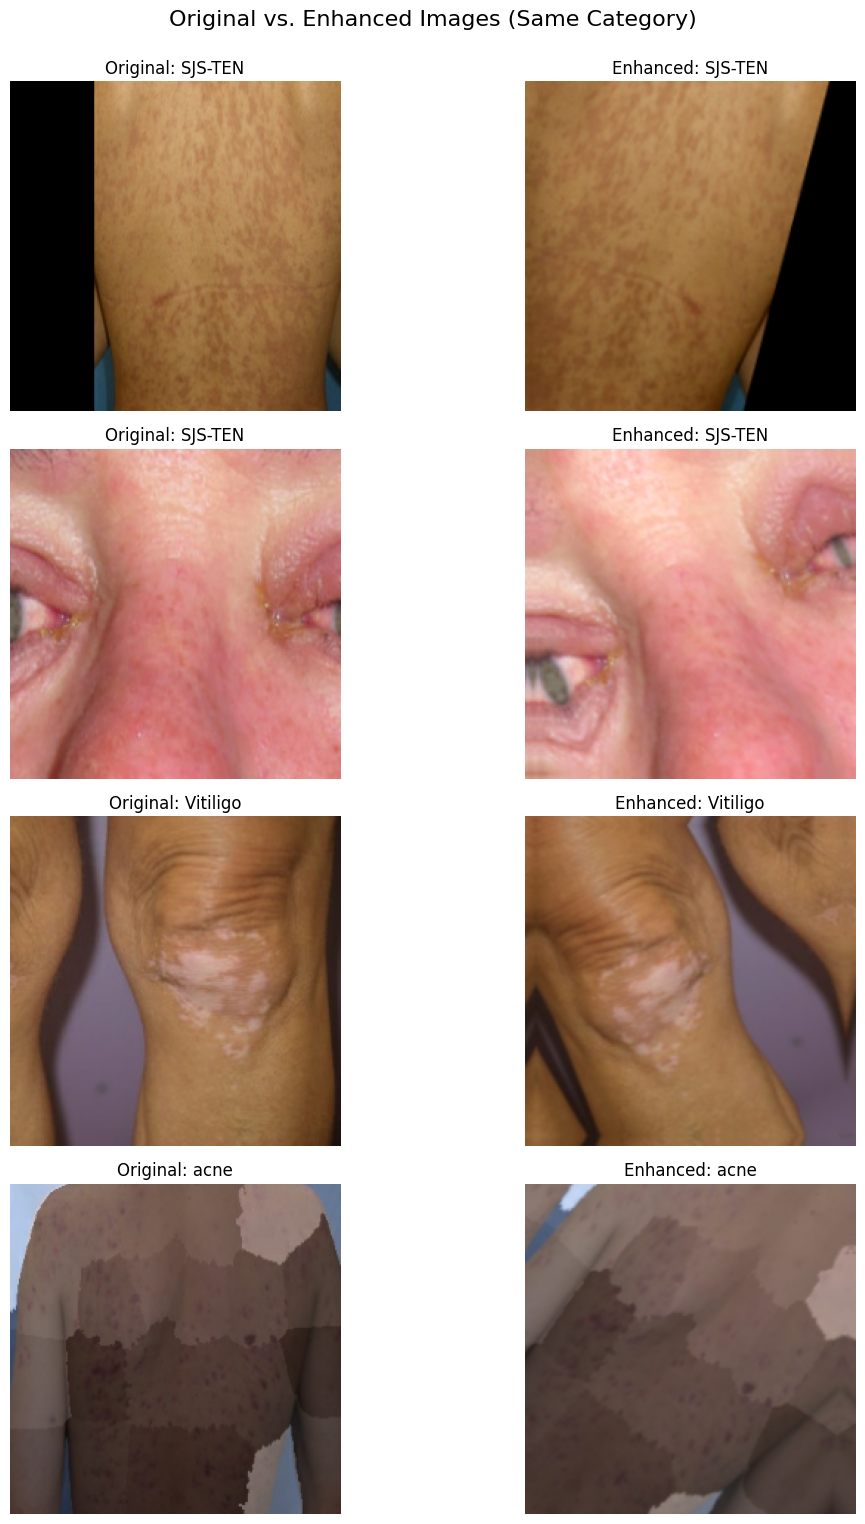

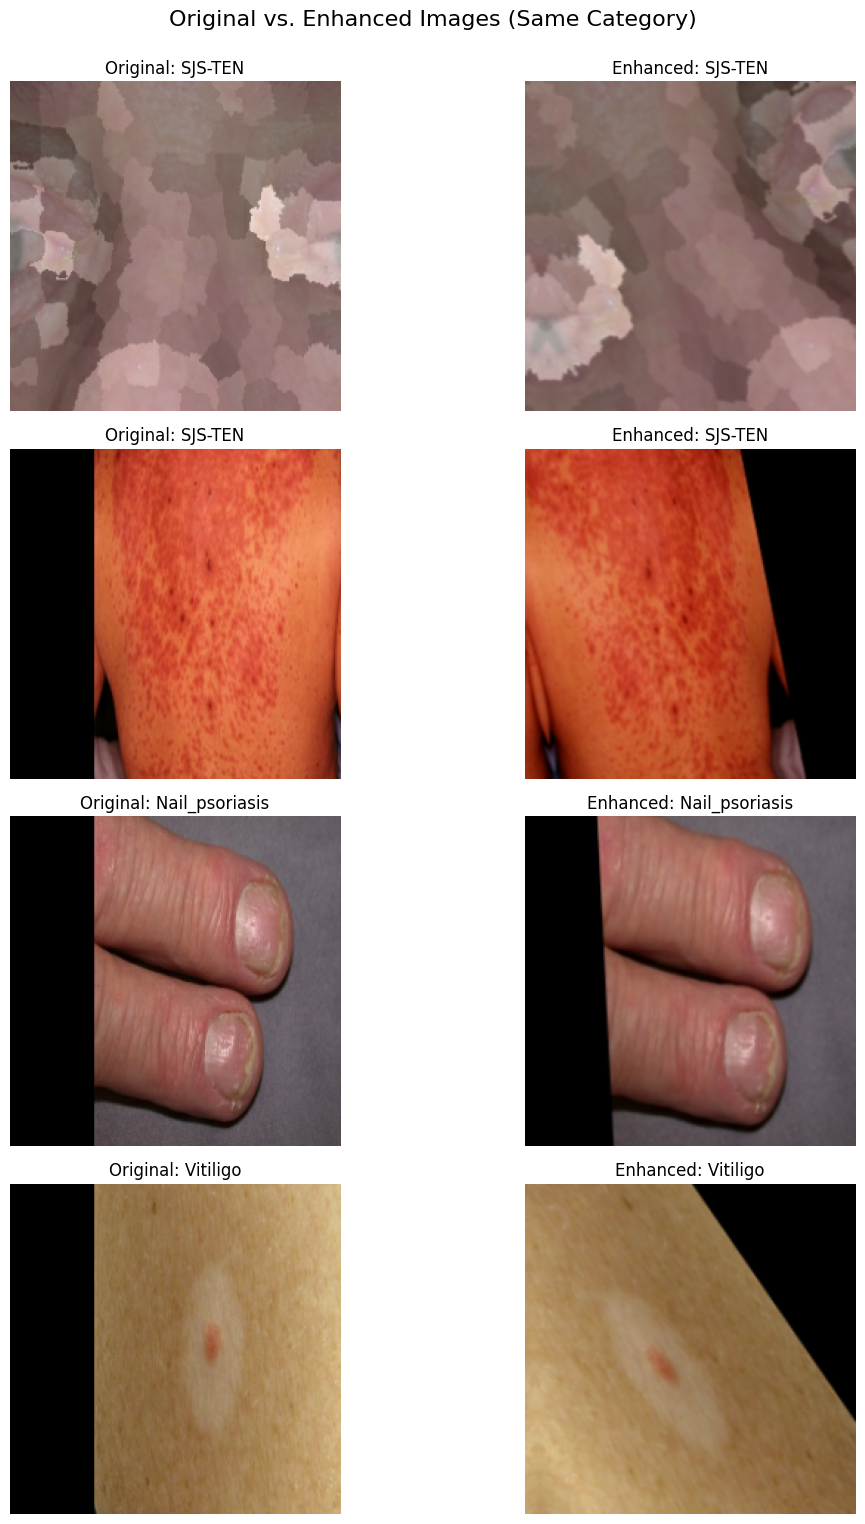

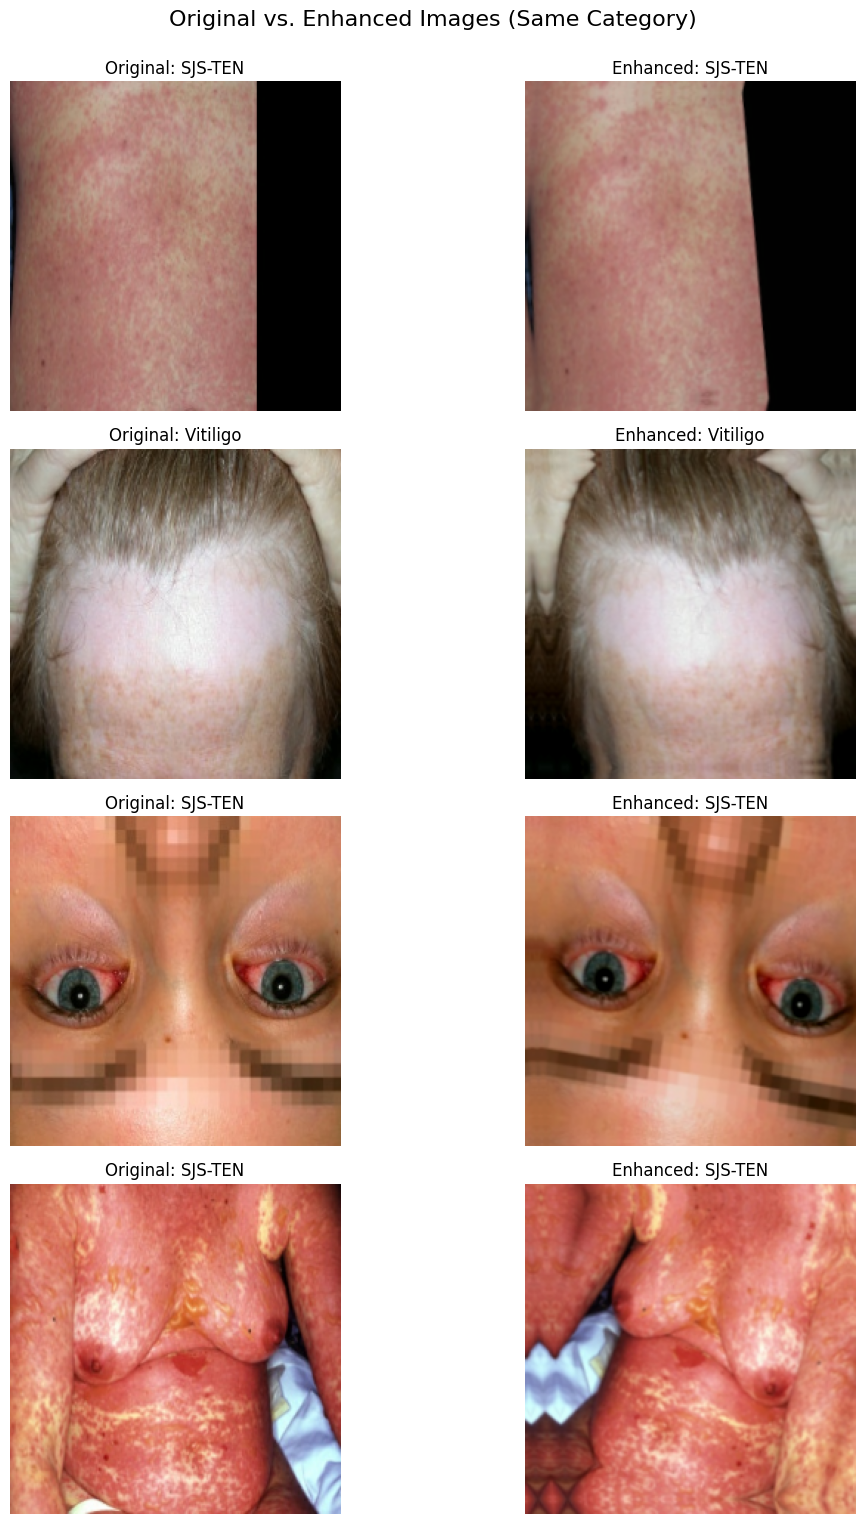

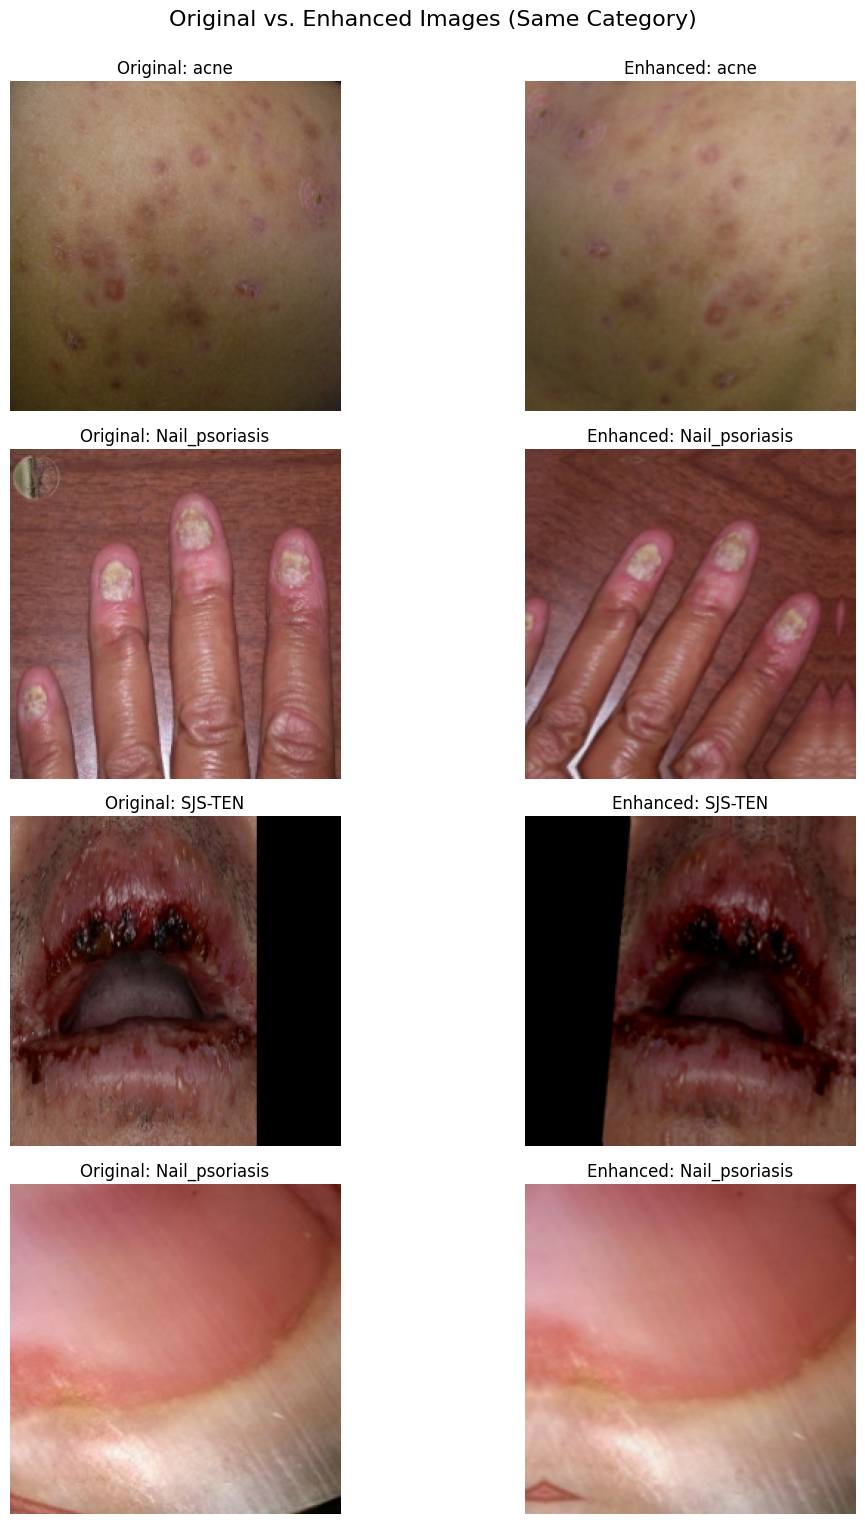

In [12]:
print("\nDisplaying side-by-side comparison of original and enhanced images...")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomShear

local_data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1),
  RandomZoom(0.1),
  RandomBrightness(0.1),
  RandomShear(0.1)
], name='local_visualization_augmentation')


# Load a single dataset with a specific batch size for visualization
vis_dataset = image_dataset_from_directory(
    DATASET_PATH,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    # It's better to turn shuffle off for predictable visualization
    shuffle=True, 
    seed=SEED,
    batch_size=8 # We specify the batch size directly here
)

# Get class_names directly from the created dataset
class_names = vis_dataset.class_names

# Take just one batch from the dataset
for original_images, original_labels in vis_dataset.take(4):
    # Apply the LOCAL augmentation directly to this batch
    augmented_images = local_data_augmentation(original_images)

    plt.figure(figsize=(12, 16))
    plt.suptitle("Original vs. Enhanced Images (Same Category)", fontsize=16)

    # CORRECTED STEP: Loop 4 times to create 4 pairs of images, filling the 4x2 grid.
    for i in range(4):
        # --- Display Original Image ---
        ax = plt.subplot(4, 2, 2 * i + 1)
        plt.imshow(original_images[i].numpy().astype("uint8"))
        label_index = np.argmax(original_labels[i])
        plt.title(f"Original: {class_names[label_index]}")
        plt.axis("off")

        # --- Display Enhanced Image ---
        ax = plt.subplot(4, 2, 2 * i + 2)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        # The label is the same, so we can reuse it
        plt.title(f"Enhanced: {class_names[label_index]}")
        plt.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

# Clean up the temporary dataset to free memory
del vis_dataset




Load the Datasets for Training

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

# --- Load Original Dataset ---
print("\nLoading original dataset for training...")
train_dataset_original, val_dataset_original = image_dataset_from_directory(
    DATASET_PATH,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset='both'
)
train_dataset_original = train_dataset_original.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset_original = val_dataset_original.cache().prefetch(buffer_size=AUTOTUNE)
print("Original dataset loaded.")

# --- Load and Create Enhanced Dataset ---
print("\nLoading and enhancing dataset for training...")
train_dataset_enhanced, val_dataset_enhanced = image_dataset_from_directory(
    DATASET_PATH,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset='both'
)
# Apply augmentation only to the training portion of the enhanced dataset
train_dataset_enhanced = train_dataset_enhanced.map(
    lambda x, y: (local_data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)
train_dataset_enhanced = train_dataset_enhanced.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset_enhanced = val_dataset_enhanced.cache().prefetch(buffer_size=AUTOTUNE)
print("Enhanced dataset created.")


Loading original dataset for training...
Found 8848 files belonging to 4 classes.
Using 7079 files for training.
Using 1769 files for validation.
Original dataset loaded.

Loading and enhancing dataset for training...
Found 8848 files belonging to 4 classes.
Using 7079 files for training.
Using 1769 files for validation.
Enhanced dataset created.


Build the Transfer Learning Model

-> This is the architectural blueprint. Instead of building a neural network from scratch, this cell uses transfer learning. 
-> It loads the powerful MobileNetV2 model, which is already an expert at seeing general shapes and textures. 
-> It then freezes this expert's knowledge and adds a small, new classifier on top that is trainable. 
-> This new part is the only thing that will learn to identify your specific skin diseases.

In [15]:
def build_transfer_learning_model(num_classes):
    """Builds a classifier using the MobileNetV2 pre-trained model."""
    base_model = MobileNetV2(input_shape=IMG_SIZE + (3,),
                             include_top=False, # Do not include the original ImageNet classifier
                             weights='imagenet') # Load weights pre-trained on ImageNet

    # Freeze the convolutional base to prevent its weights from being updated
    base_model.trainable = False

    # Create a new model on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Get the number of classes and build two separate models
num_classes = len(class_names)
model_for_original = build_transfer_learning_model(num_classes)
model_for_enhanced = build_transfer_learning_model(num_classes)

print("\n--- Transfer Learning Model Architecture ---")
model_for_original.summary()


--- Transfer Learning Model Architecture ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train and Evaluate on the ORIGINAL Dataset

In [16]:
print("\n\n--- Training on ORIGINAL Dataset ---")
history_original = model_for_original.fit(
    train_dataset_original,
    validation_data=val_dataset_original,
    epochs=EPOCHS,
    verbose=1
)
print("\n--- Evaluating on ORIGINAL Dataset ---")
loss_original, accuracy_original = model_for_original.evaluate(val_dataset_original, verbose=0)
print(f"Final Validation Accuracy (Original Data): {accuracy_original * 100:.2f}%")



--- Training on ORIGINAL Dataset ---
Epoch 1/15


222/222 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.4626 - loss: 1.2767 - val_accuracy: 0.6071 - val_loss: 0.9594
Epoch 2/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.5755 - loss: 0.9958 - val_accuracy: 0.6512 - val_loss: 0.8712
Epoch 3/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.6110 - loss: 0.9175 - val_accuracy: 0.6676 - val_loss: 0.8397
Epoch 4/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.6330 - loss: 0.8753 - val_accuracy: 0.6795 - val_loss: 0.8012
Epoch 5/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.6439 - loss: 0.8506 - val_accuracy: 0.6857 - val_loss: 0.7834
Epoch 6/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.6518 - loss: 0.8319 - val_accuracy: 0.6914 - val_loss: 0.7741
Epoch 7/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.6631 - loss: 0.8189 - val_accuracy: 0.6908 - val_loss: 0.7587
Epoch 8/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.6563 - loss: 0.8241 - val_accuracy: 0.689

Train and Evaluate on the ENHANCED Dataset

In [17]:
print("\n\n--- Training on ENHANCED Dataset ---")
history_enhanced = model_for_enhanced.fit(
    train_dataset_enhanced,
    validation_data=val_dataset_enhanced,
    epochs=EPOCHS,
    verbose=1
)
print("\n--- Evaluating on ENHANCED Dataset ---")
loss_enhanced, accuracy_enhanced = model_for_enhanced.evaluate(val_dataset_enhanced, verbose=0)
print(f"Final Validation Accuracy (Enhanced Data): {accuracy_enhanced * 100:.2f}%")




--- Training on ENHANCED Dataset ---
Epoch 1/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.4533 - loss: 1.3198 - val_accuracy: 0.4969 - val_loss: 1.1047
Epoch 2/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.5535 - loss: 1.0528 - val_accuracy: 0.4929 - val_loss: 1.1194
Epoch 3/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.5792 - loss: 0.9901 - val_accuracy: 0.4873 - val_loss: 1.1146
Epoch 4/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.5850 - loss: 0.9619 - val_accuracy: 0.5025 - val_loss: 1.0802
Epoch 5/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - accuracy: 0.6087 - loss: 0.9362 - val_accuracy: 0.5212 - val_loss: 1.0634
Epoch 6/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 451s 2s/step - accuracy: 0.6160 - loss: 0.9300 - val_accuracy: 0.5133 - val_loss: 1.0698
Epoch 7/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.6084 - loss: 0.9330 - val_accuracy: 0.4771 - val_loss: 1.1487
Epoch 8/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - acc

Compare the Final Results



--- FINAL ACCURACY COMPARISON ---
Validation Accuracy (Original Data): 72.36%
Validation Accuracy (Enhanced Data): 52.40%
-----------------------------------


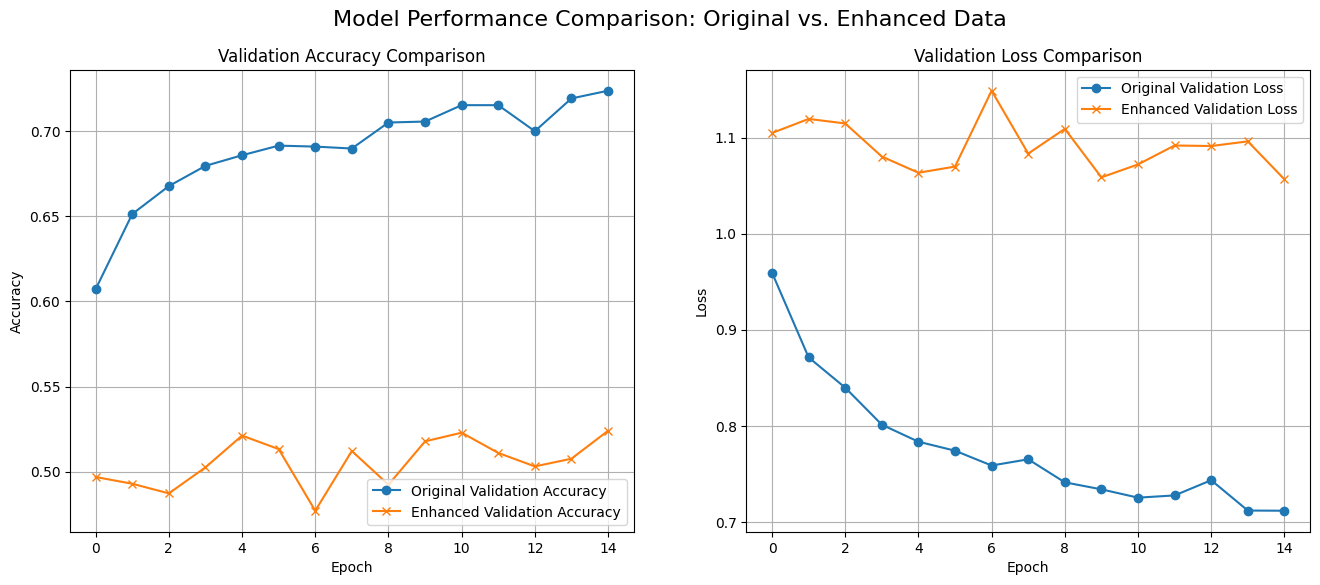

In [18]:
print("\n\n--- FINAL ACCURACY COMPARISON ---")
print(f"Validation Accuracy (Original Data): {accuracy_original * 100:.2f}%")
print(f"Validation Accuracy (Enhanced Data): {accuracy_enhanced * 100:.2f}%")
print("-----------------------------------")

# Plotting the results for a visual comparison
acc_original = history_original.history['accuracy']
val_acc_original = history_original.history['val_accuracy']
acc_enhanced = history_enhanced.history['accuracy']
val_acc_enhanced = history_enhanced.history['val_accuracy']

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), val_acc_original, label='Original Validation Accuracy', marker='o')
plt.plot(range(EPOCHS), val_acc_enhanced, label='Enhanced Validation Accuracy', marker='x')
plt.legend(loc='lower right')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

loss_original_hist = history_original.history['val_loss']
loss_enhanced_hist = history_enhanced.history['val_loss']

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_original_hist, label='Original Validation Loss', marker='o')
plt.plot(range(EPOCHS), loss_enhanced_hist, label='Enhanced Validation Loss', marker='x')
plt.legend(loc='upper right')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.suptitle('Model Performance Comparison: Original vs. Enhanced Data', fontsize=16)
plt.show()
